# 1. Análisis exploratorio de datos (EDA)
- Se pretende comprender los videos que proporciona SoccerNet: https://www.soccer-net.org/
- Identificar si los datos reflejan patrones de juego realistas.
- Con el EDA no se pretende utilizar todos los eventos etiquetados de SoccerNet, sino realizar un pipeline de filtrado de eventos "consistentes" para que un modelo de red neuronal convolucional (CNN) los aprenda.

SoccerNet brinda 500 partidos agrupados en 6 principales ligas europeas.

De los 500 partidos, se descontarán 6 (1 por cada liga) para tareas de inferencia; más 1 partido (index=483) que da error al decodificarlo. Por tanto nos queda 493 partidos a analizar.

Cada partido contiene un .json del cual se extrajeron los datos y se almacenaron en 2 archivos .csv, uno con los atributos del partido y otro con los detalles específicos de los eventos.

Librerías a utilizar y configuraciones previas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np

# configuración de los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14

# 2. games.csv

Cargamos el archivo games.csv en un DataFrame de pandas y mostramos las primeras filas:

In [2]:
df_games = pd.read_csv("../results/soccernet/games.csv", sep=",")
df_games.head()

,index,UrlLocal,UrlYoutube,gameAwayTeam,gameDate,gameHomeTeam,gameScore
0,0,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,NaN,Burnley,21/02/2015 - 18:00,Chelsea,1 - 1
1,1,england_epl/2014-2015/2015-02-21 - 18-00 Cryst...,NaN,Arsenal,21/02/2015 - 18:00,Crystal Palace,1 - 2
2,2,england_epl/2014-2015/2015-02-21 - 18-00 Swans...,NaN,Manchester United,21/02/2015 - 18:00,Swansea,2 - 1
3,3,england_epl/2014-2015/2015-02-22 - 19-15 South...,NaN,Liverpool,22/02/2015 - 19:15,Southampton,0 - 2
4,4,england_epl/2015-2016/2015-08-08 - 19-30 Chels...,NaN,Swansea,08/08/2015 - 19:30,Chelsea,2 - 2


Eliminamos la columna 'UrlYoutube' del DataFrame df_games por no ser relevante:

In [3]:
if "UrlYoutube" in df_games.columns:
    df_games = df_games.drop(columns=["UrlYoutube"])

Mostramos un resumen de la información de df_games, incluyendo tipos de datos:

In [4]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         493 non-null    int64 
 1   UrlLocal      493 non-null    object
 2   gameAwayTeam  493 non-null    object
 3   gameDate      493 non-null    object
 4   gameHomeTeam  493 non-null    object
 5   gameScore     493 non-null    object
dtypes: int64(1), object(5)
memory usage: 23.2+ KB


Convertimos ciertas columnas tipo 'object' a tipo 'string' para optimizar memoria y usar funciones de cadena:

In [5]:
list_object_df1 = ["UrlLocal", "gameAwayTeam", "gameDate", "gameHomeTeam", "gameScore"]
df_games[list_object_df1] = df_games[list_object_df1].astype("string")
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         493 non-null    int64 
 1   UrlLocal      493 non-null    string
 2   gameAwayTeam  493 non-null    string
 3   gameDate      493 non-null    string
 4   gameHomeTeam  493 non-null    string
 5   gameScore     493 non-null    string
dtypes: int64(1), string(5)
memory usage: 23.2 KB


Verificamos si existen valores nulos:

In [6]:
df_games.isnull().sum()

index           0
UrlLocal        0
gameAwayTeam    0
gameDate        0
gameHomeTeam    0
gameScore       0
dtype: int64

Para un mejor manejo de los datos, dividimos ciertas columnas para extraer: liga, temporada, fecha, hora, scoreHome y scoreAway.

Eliminamos las columnas originales y reordenamos las columnas del DataFrame.

In [7]:
# separar para mejor manejo
df_games["liga"] = df_games["UrlLocal"].str.split("/").str[0]
df_games["temporada"] = df_games["UrlLocal"].str.split("/").str[1]
df_games["fecha"] = df_games["gameDate"].str.split(" - ").str[0]
df_games["hora"] = df_games["gameDate"].str.split(" - ").str[1]
df_games["scoreHome"] = df_games["gameScore"].str.split(" - ").str[0]
df_games["scoreAway"] = df_games["gameScore"].str.split(" - ").str[1]

# ya no nos sirve 'UrlLocal' ni 'gameDate' ni 'gameScore'
df_games = df_games.drop(columns=["UrlLocal", "gameDate", "gameScore"])

# ordenado
orden_df1 = ["index", "liga", "temporada", "fecha", "hora", "gameHomeTeam", "gameAwayTeam", "scoreHome", "scoreAway"]
df_games = df_games[orden_df1]
df_games.head()
#df_games.tail()

,index,liga,temporada,fecha,hora,gameHomeTeam,gameAwayTeam,scoreHome,scoreAway
0,0,england_epl,2014-2015,21/02/2015,18:00,Chelsea,Burnley,1,1
1,1,england_epl,2014-2015,21/02/2015,18:00,Crystal Palace,Arsenal,1,2
2,2,england_epl,2014-2015,21/02/2015,18:00,Swansea,Manchester United,2,1
3,3,england_epl,2014-2015,22/02/2015,19:15,Southampton,Liverpool,0,2
4,4,england_epl,2015-2016,08/08/2015,19:30,Chelsea,Swansea,2,2


Comprensión de las estadísticas descriptivas.

Sólo para datos tipo 'string'.

In [8]:
lista_interes_df1 = ["liga", "temporada", "fecha", "hora", "gameHomeTeam", "gameAwayTeam", "scoreHome", "scoreAway"]
df_games[lista_interes_df1].describe()

,liga,temporada,fecha,hora,gameHomeTeam,gameAwayTeam,scoreHome,scoreAway
count,493,493,493,493,493,493,493,493
unique,6,3,215,32,125,112,9,9
top,spain_laliga,2016-2017,26/09/2015,22:45,Real Madrid,Real Madrid,1,0
freq,115,253,9,94,46,43,146,149


# 3. detalle.csv

Cargamos el archivo detalle.csv en un DataFrame de pandas y mostramos las primeras filas:

In [9]:
df_detalle = pd.read_csv("../results/soccernet/detalle.csv", sep=",")
df_detalle.head()

,game_index,gameTime,label,position,team,visibility
0,0,1 - 00:00,Kick-off,0,away,visible
1,0,1 - 02:13,Ball out of play,133295,not applicable,visible
2,0,1 - 02:29,Throw-in,149168,away,visible
3,0,1 - 02:36,Ball out of play,156098,not applicable,visible
4,0,1 - 03:02,Corner,182775,away,visible


Eliminamos la columna 'position' del DataFrame df_detalle por no ser relevante:

In [10]:
if "position" in df_detalle.columns:
    df_detalle = df_detalle.drop(columns=["position"])

Mostramos un resumen de la información de df_detalle, incluyendo tipos de datos:

In [11]:
df_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108997 entries, 0 to 108996
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   game_index  108997 non-null  int64 
 1   gameTime    108997 non-null  object
 2   label       108997 non-null  object
 3   team        108997 non-null  object
 4   visibility  108997 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


Convertimos ciertas columnas tipo 'object' a tipo 'string' para optimizar memoria y usar funciones de cadena:

In [12]:
list_object_df2 = ["gameTime", "label", "team", "visibility"]
df_detalle[list_object_df2] = df_detalle[list_object_df2].astype("string")
df_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108997 entries, 0 to 108996
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   game_index  108997 non-null  int64 
 1   gameTime    108997 non-null  string
 2   label       108997 non-null  string
 3   team        108997 non-null  string
 4   visibility  108997 non-null  string
dtypes: int64(1), string(4)
memory usage: 4.2 MB


Verificamos si existen valores nulos:

In [13]:
df_detalle.isnull().sum()

game_index    0
gameTime      0
label         0
team          0
visibility    0
dtype: int64

Para un mejor manejo de los datos, dividimos ciertas columnas para extraer: mitad, instante, instante_minutos.

Eliminamos las columnas originales y reordenamos las columnas del DataFrame.

In [14]:
# separar para mejor manejo
df_detalle["mitad"] = df_detalle["gameTime"].str.split(" - ").str[0]
df_detalle["instante"] = df_detalle["gameTime"].str.split(" - ").str[1]

# ya no nos sirve 'gameTime'
df_detalle = df_detalle.drop(columns=["gameTime"])

# 'instante' en minutos
df_detalle["instante_minutos"] = pd.to_timedelta("00:" + df_detalle["instante"]).dt.total_seconds() / 60
df_detalle["instante_minutos"] += df_detalle["mitad"].apply(lambda x: 45 if x == "2" else 0)
df_detalle["instante_minutos"] = df_detalle["instante_minutos"].round(2)

# ordenado
orden_df2 = ["game_index", "label", "mitad", "instante", "instante_minutos", "team", "visibility"]
df_detalle = df_detalle[orden_df2]
df_detalle.head()
#df_detalle.tail()

,game_index,label,mitad,instante,instante_minutos,team,visibility
0,0,Kick-off,1,00:00,0.00,away,visible
1,0,Ball out of play,1,02:13,2.22,not applicable,visible
2,0,Throw-in,1,02:29,2.48,away,visible
3,0,Ball out of play,1,02:36,2.60,not applicable,visible
4,0,Corner,1,03:02,3.03,away,visible


Comprensión de las estadísticas descriptivas.

Sólo para datos tipo 'string'.

In [15]:
lista_interes_df2 = ["label", "mitad", "instante", "team", "visibility"]
df_detalle[lista_interes_df2].describe()

,label,mitad,instante,team,visibility
count,108997,108997,108997,108997,108997
unique,17,2,3048,3,2
top,Ball out of play,2,00:00,home,visible
freq,31379,56395,1083,39349,89580


# 4. Balance del Dataset General - distribución de partidos por LIGA
- Analizar la distribución de los partidos de fútbol en el dataset a lo largo de las diferentes ligas.
- Esto ayuda a entender si el dataset tiene una representación equilibrada de las distintas competiciones o si hay ligas predominantes.

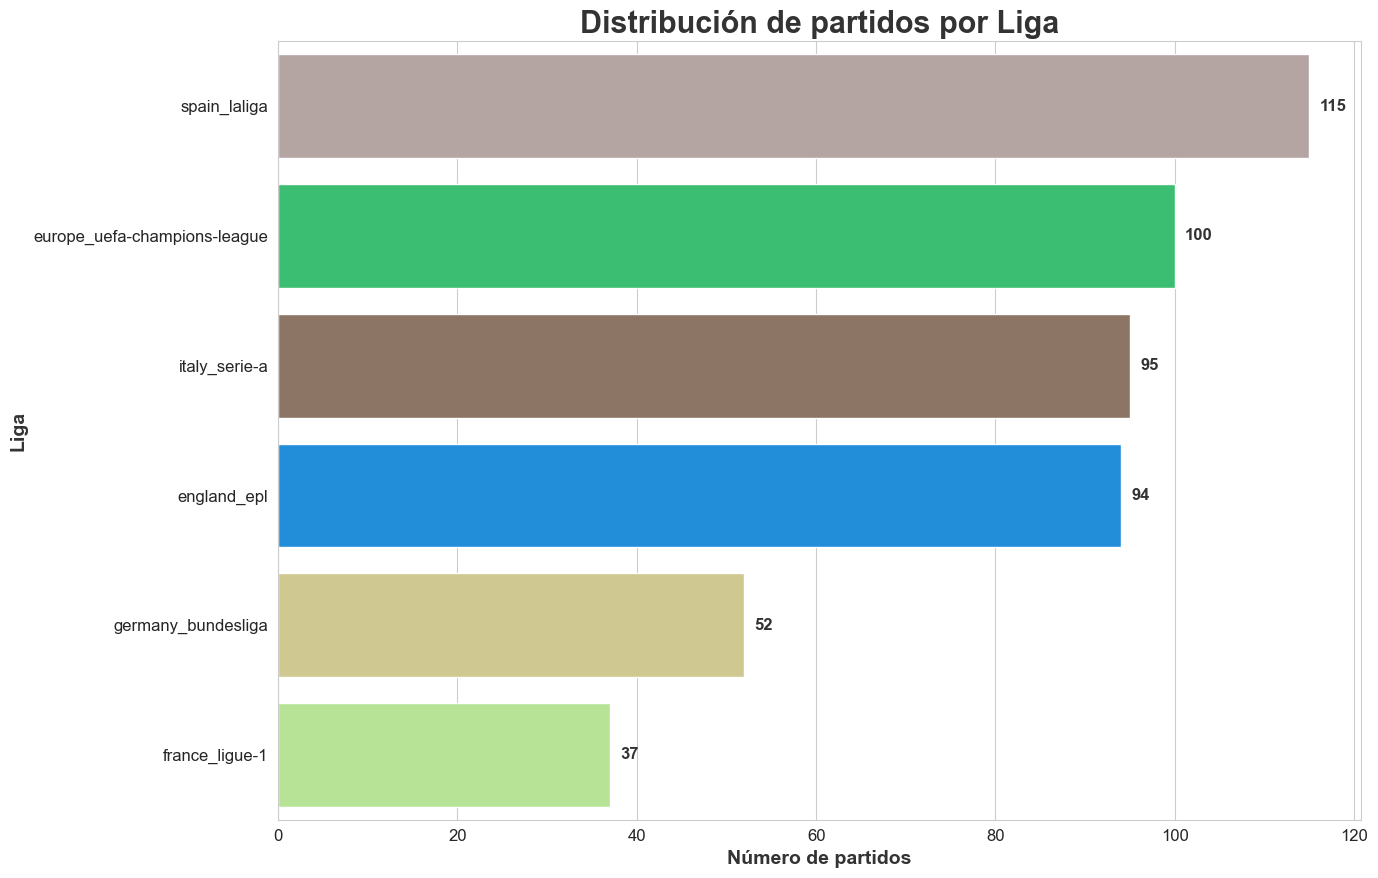

In [16]:
#sns.set_style(style="whitegrid")

# Conteo de partidos por liga
ax = sns.countplot(
    data=df_games,
    y="liga",
    #palette="viridis_r",
    palette="terrain",
    hue="liga",
    legend=False,
    order=df_games["liga"].value_counts().index,
)

plt.title("Distribución de partidos por Liga", fontsize=22, weight="bold", color="#333333")
plt.xlabel("Número de partidos", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Liga", fontsize=14, weight="bold", color="#333333")

# Etiquetas de conteo al final de cada barra
for p in ax.patches:
    count = int(p.get_width())
    ax.annotate(
        f'{count}',
        (p.get_width() + max(df_games["liga"].value_counts()) * 0.01, p.get_y() + p.get_height() / 2),
        ha='left',
        va='center',
        fontsize=12,
        color="#333333",
        weight="bold",
    )

# Eliminar líneas del eje derecho y superior
#sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

- El gráfico revela la procedencia de los datos utilizados.
- Se observa una distribución mayoritaria en la liga 'spain_laliga' con 115 partidos y mucho menor en la liga 'france_ligue-1' con sólo 37 partidos.
- Una distribución equitativa entre competiciones sería lo ideal, para que el modelo aprenda a generalizar entre diferentes estilos de juego.
- Aunque el objetivo del proyecto es únicamente detectar eventos clave, mas no estilos de juego.

# 5. Distribución temporal de eventos
- Se busca entender cómo se distribuyen los eventos registrados a lo largo del tiempo durante un partido de fútbol.
- Esto es útil para identificar patrones, momentos de mayor actividad y confirmar si la distribución temporal de los datos se asemeja a un partido real.

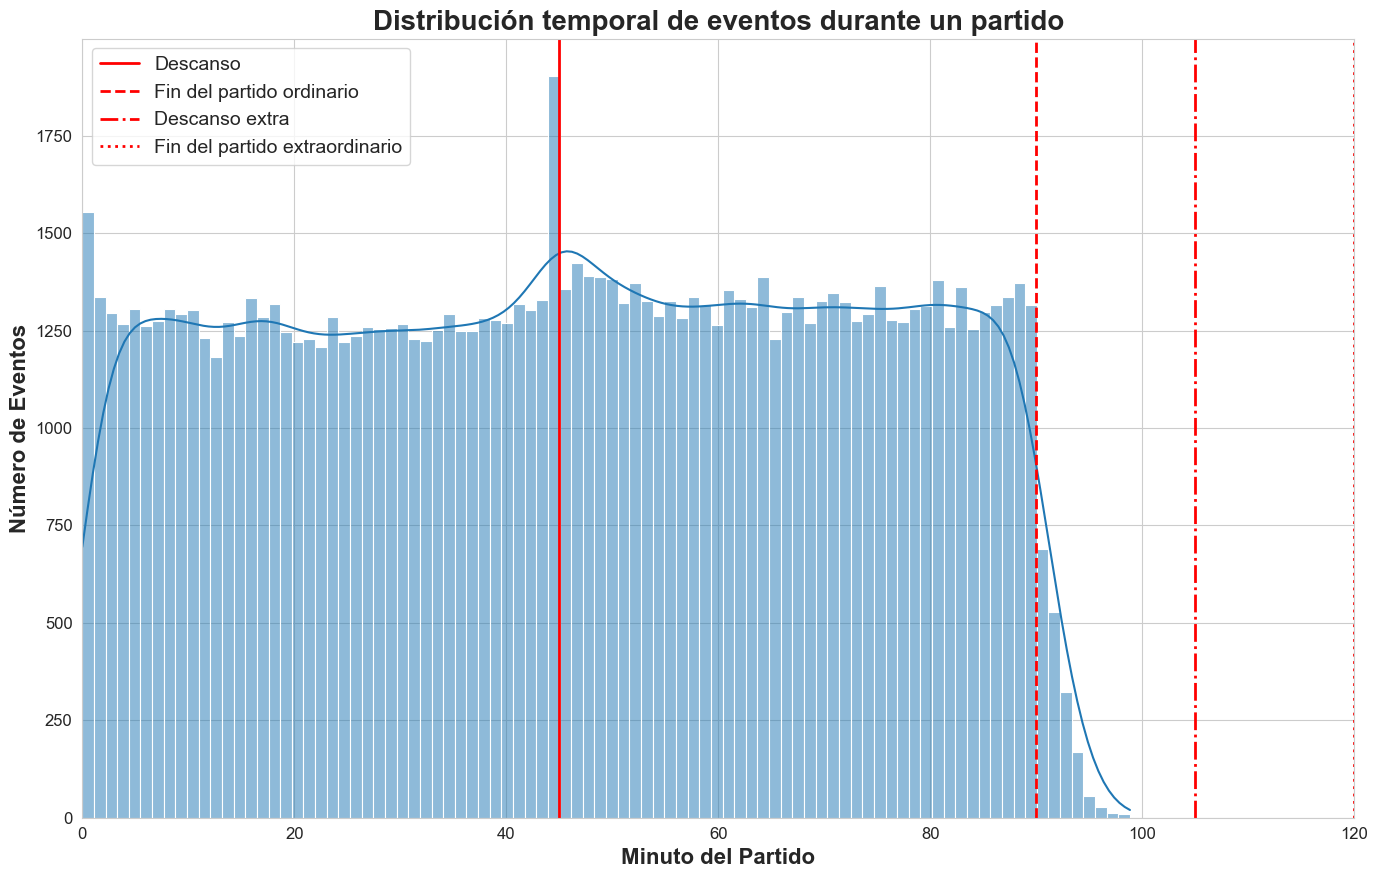

In [17]:
# histograma con una curva de densidad (KDE)
sns.histplot(
    data=df_detalle,
    x="instante_minutos",
    kde=True, # Añade una línea de densidad para suavizar la distribución
    bins=90, # Aproximadamente un bin por minuto
    #palette="terrain",
    #hue="instante_minutos",
)

# Añadir líneas verticales para marcar hitos
#plt.axvline(45, color="red", linestyle="--", linewidth=2, label="Fin del primer tiempo")
#plt.axvline(47, color="red", linestyle=":", linewidth=2, label="Inicio del segundo tiempo")
plt.axvline(45, color="red", linestyle="-", linewidth=2, label="Descanso")
plt.axvline(90, color="red", linestyle="--", linewidth=2, label="Fin del partido ordinario")
plt.axvline(105, color="red", linestyle="-.", linewidth=2, label="Descanso extra")
plt.axvline(120, color="red", linestyle=":", linewidth=2, label="Fin del partido extraordinario")

plt.title('Distribución temporal de eventos durante un partido', fontsize=20, weight='bold')
plt.xlabel('Minuto del Partido', weight='bold')
plt.ylabel('Número de Eventos', weight='bold')
plt.xlim(0, 120)
plt.legend()
plt.tight_layout()
plt.show()

- Este análisis de distribución temporal nos permite validar si nuestros datos reflejan patrones de juego realistas.
- La caída drástica de eventos alrededor del minuto 90 corresponde lógicamente al final del partido.
- Observamos también que no hay datos de tiempo extra, mucho menos eventos como penaltis al final de estos 120 minutos.
- Esta distribución confirma que el dataset no tiene sesgos temporales anómalos y captura la cadencia natural de un partido de fútbol; por tanto nuestros datos son válidos y sirven para entrenar un modelo de Deep Learning.

# 6. Filtrado y selección de eventos clave
- Los videos tiene vista isométrica, las ventajas y desventajas se detallan en el TFM. Se plantea 4 aspectos **TODO citar fuente** para agrupar los 17 eventos:
    - Eventos de alto impacto o firma visual clara:
        - Goal, Yellow card, Red card, Yellow->red card, Substitution, Kick-off.
    - Eventos tipo "jugada preparada":
        - Penalty, Corner, Throw-in, Indirect free-kick, Direct free-kick.
    - Eventos de interacción o movimiento del balón:
        - Foul, Clearance, Shots on target, Shots off target, Ball out of play.
    - Eventos complejos con la vista isométrica:
        - Offside.
- Esta agrupación no quiere decir que el modelo-IA deba aprender los 6 eventos del primer aspecto. Primero se deben considerar los siguientes criterios:
    - **Frecuencia y relevancia:** ¿Es el evento lo suficientemente común para ser modelado y relevante para un video-resumen?
    - **Visibilidad:** Dado que tenemos la variable de visibilidad de un evento ¿Es el evento visible para que un modelo-IA pueda aprender correctamente a diferenciarlo?
    - **Aislamiento temporal:** ¿Durante cuánto tiempo ocurre el evento de manera pura o aislada, sin que otro evento intervenga?

**6.1. Frecuencia y relevancia:**
- Analizamos la frecuencia de todas las acciones disponibles.
- Un evento debe ser lo suficientemente frecuente para que el modelo-IA tenga suficientes ejemplos para aprender.
- Eventos muy raros son casi imposibles de modelar, y eventos de altísima frecuencia pero bajo impacto pueden ser considerados "ruido" para el video-resumen.

In [18]:
def fn_listar_eventos_unicos(df, columna, pri=False):
    eventos_unicos = df[columna].unique()

    if pri:
        #print(eventos_unicos)
        for evento in eventos_unicos:
            print(f'"{evento}"')
    
    return list(eventos_unicos)

In [19]:
lista_eventos = fn_listar_eventos_unicos(df_detalle, "label", pri=True)

"Kick-off"
"Ball out of play"
"Throw-in"
"Corner"
"Shots on target"
"Offside"
"Shots off target"
"Clearance"
"Goal"
"Foul"
"Yellow card"
"Indirect free-kick"
"Direct free-kick"
"Substitution"
"Red card"
"Penalty"
"Yellow->red card"


In [20]:
# Conteo de eventos por clase
def fn_frecuencia_eventos(data_frame, columna, palette="terrain"):
    ax = sns.countplot(
        data=data_frame,
        #x=columna,
        y=columna,
        order=data_frame[columna].value_counts().index,
        palette=palette,
        hue=columna,
        legend=False,
    )

    plt.title("Balance de clases de eventos en el dataset", fontsize=22, weight="bold", color="#333333")
    plt.xlabel("Frecuencia absoluta (conteo)", fontsize=14, weight="bold", color="#333333")
    plt.ylabel("Tipo de evento", fontsize=14, weight="bold", color="#333333")
    #plt.yticks(rotation=15)

    # etiquetas de conteo
    for p in ax.patches:
        width = int(p.get_width())
        ax.annotate(
            f"{width}",
            (width + width * 0.01, p.get_y() + p.get_height() / 2),
            ha="left",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            fontsize=12,
            weight="bold",
        )

    plt.tight_layout()
    plt.show()

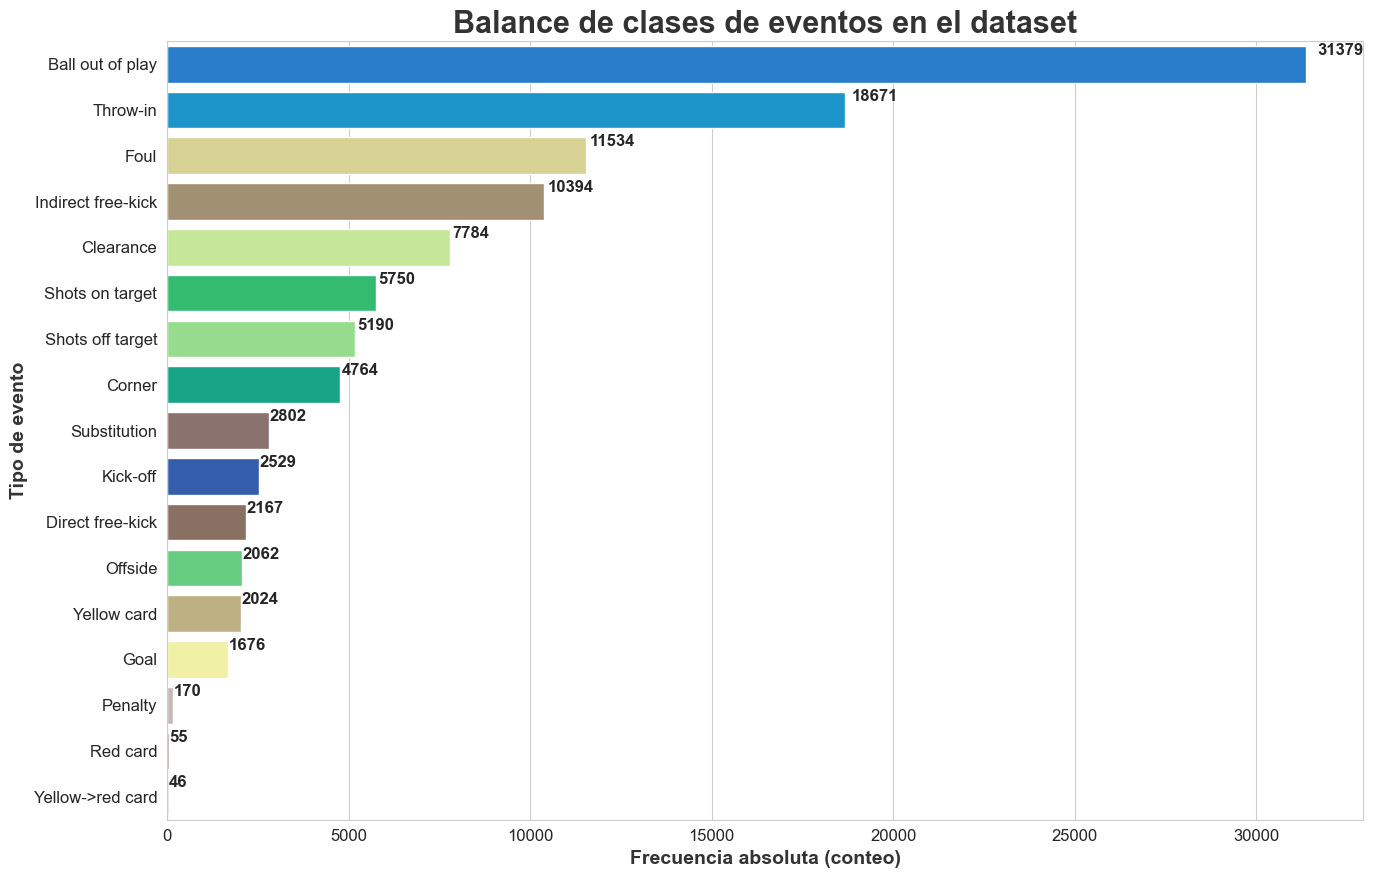

In [21]:
fn_frecuencia_eventos(
    data_frame=df_detalle,
    columna="label",
)

- El análisis del balance de clases es, quizás, el más crítico para un problema de clasificación.
- La gráfica revela un marcado desequilibrio.
- Clases como 'Ball out of play' y 'Throw-in' son mucho más frecuentes que 'Penalty'.
- Este desequilibrio es un problema, ya que puede sesgar el entrenamiento del modelo.
- Entrenar un modelo-IA con estos datos (sin tratamiento previo) provocaría que el modelo se vuelva un experto en predecir clases mayoritarias, ignorando las demás y resultando en un rendimiento pobre en la práctica.
- Por tanto, este hallazgo justifica la exclusión de eventos mayoritarios y minoritarios.

In [22]:
lista_eventos_final = lista_eventos
lista_eventos_final.remove("Ball out of play")
lista_eventos_final.remove("Throw-in")
lista_eventos_final.remove("Foul")
lista_eventos_final.remove("Penalty")
lista_eventos_final.remove("Red card")
lista_eventos_final.remove("Yellow->red card")

# filtrando eventos
df_detalle_final = df_detalle[df_detalle["label"].isin(lista_eventos_final)].copy()
lista_eventos = fn_listar_eventos_unicos(df_detalle_final, "label", pri=True)

"Kick-off"
"Corner"
"Shots on target"
"Offside"
"Shots off target"
"Clearance"
"Goal"
"Yellow card"
"Indirect free-kick"
"Direct free-kick"
"Substitution"


**6.2. Visibilidad:**
- Independientemente de si un evento es muy frecuente o muy raro... ¿Qué porcentaje de sus ocurrencias tuvieron visibilidad?

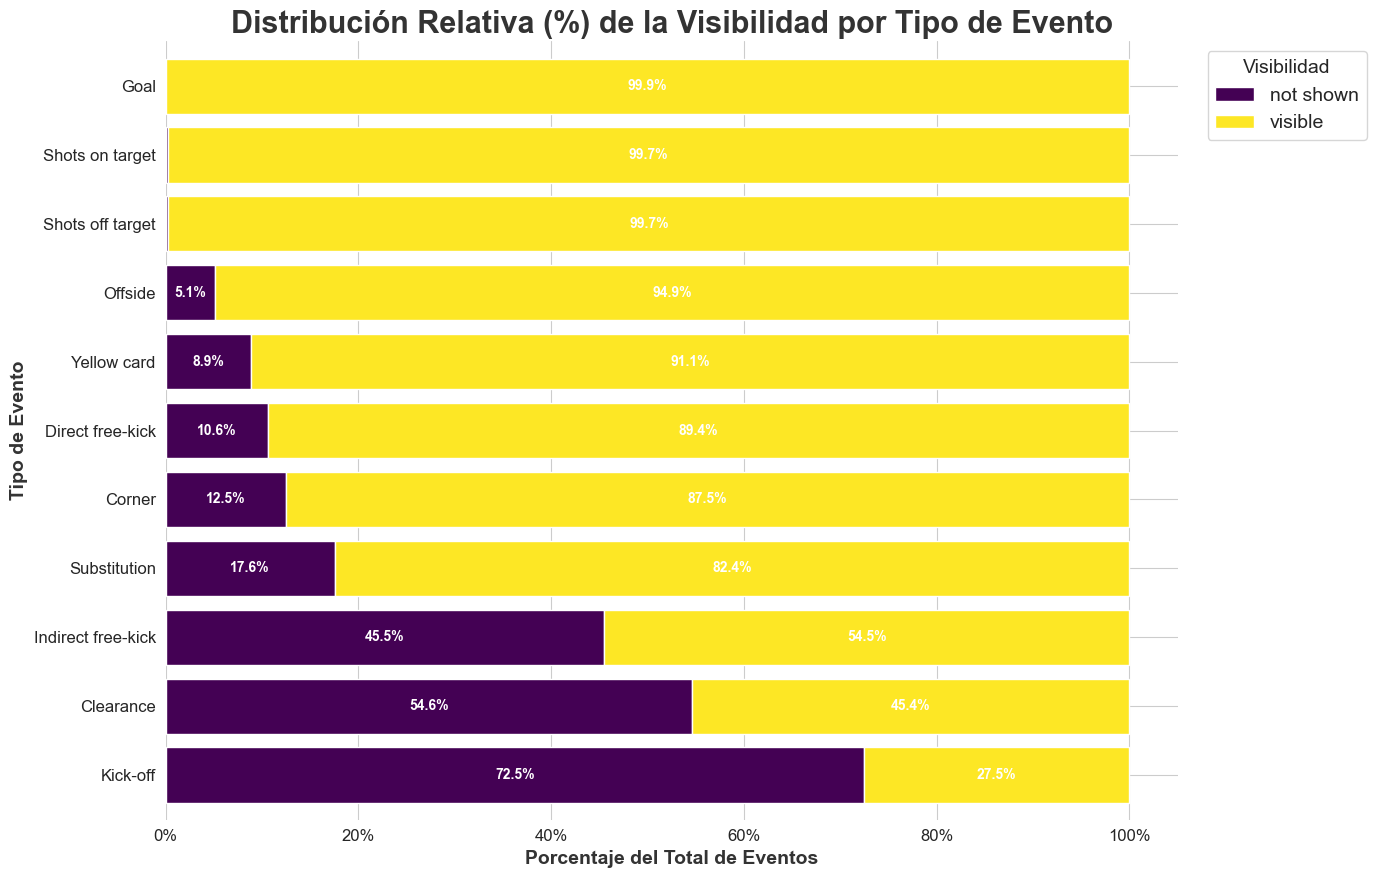

In [23]:
# Transformación de Datos
# Creamos una tabla de contingencia (crosstab) para obtener los conteos
ct = pd.crosstab(df_detalle_final['label'], df_detalle_final['visibility'])

# Normalizamos por fila para obtener porcentajes (de 0 a 1)
ct_normalized = ct.div(ct.sum(axis=1), axis=0)

# Ordenamos el DataFrame por visibilidad
ct_sorted = ct_normalized.sort_values(by="visible", ascending=True)

sns.set_style("whitegrid")
ax = ct_sorted.plot(
    kind='barh',  # Gráfico de barras horizontal
    stacked=True,  # apilado
    #figsize=(14, 10),
    width=0.8,
    colormap='viridis',
)

# Títulos y Formato
plt.title("Distribución Relativa (%) de la Visibilidad por Tipo de Evento", fontsize=22, weight="bold", color="#333333")
plt.xlabel("Porcentaje del Total de Eventos", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Tipo de Evento", fontsize=14, weight="bold", color="#333333")

# Formatear el eje X para que muestre porcentajes
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Mover y mejorar la leyenda
plt.legend(title='Visibilidad', bbox_to_anchor=(1.02, 1), loc='upper left')

# Anotaciones de Porcentaje (Opcional, pero muy útil)
for c in ax.containers:
    labels = [f'{w*100:.1f}%' if (w := v.get_width()) > 0.05 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=10)


# Limpieza Final
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

- Comparación justa:
    - Se puede comparar la distribución de visibilidad entre un evento muy común y uno muy raro en igualdad de condiciones.
- Revelando patrones:
    - Aunque el evento "Goal" es menos frecuente que "Indirect free-kick" o "Clearance", proporcionalmente su visibilidad ocurre mucho más a menudo (99.90%).
- Por tanto, este nuevo hallazgo justifica la exclusión de eventos cuya NO visibilidad tienen porcentaje medianamente alto.

In [24]:
lista_eventos_final = lista_eventos
lista_eventos_final.remove("Kick-off")
lista_eventos_final.remove("Clearance")
lista_eventos_final.remove("Indirect free-kick")

# filtrando eventos
df_detalle_final = df_detalle_final[df_detalle_final["label"].isin(lista_eventos_final)]
lista_eventos = fn_listar_eventos_unicos(df_detalle_final, "label", pri=True)

"Corner"
"Shots on target"
"Offside"
"Shots off target"
"Goal"
"Yellow card"
"Direct free-kick"
"Substitution"


**6.3. Aislamiento temporal:**
- Se busca entender cuánto tiempo transcurre entre un evento específico y el evento más cercano a él (ya sea el anterior o el siguiente) dentro del mismo partido y mitad.
- Esto nos ayudará a identificar qué eventos ocurren de manera más aislada en el tiempo, sin la superposición o cercanía inmediata de otros eventos.

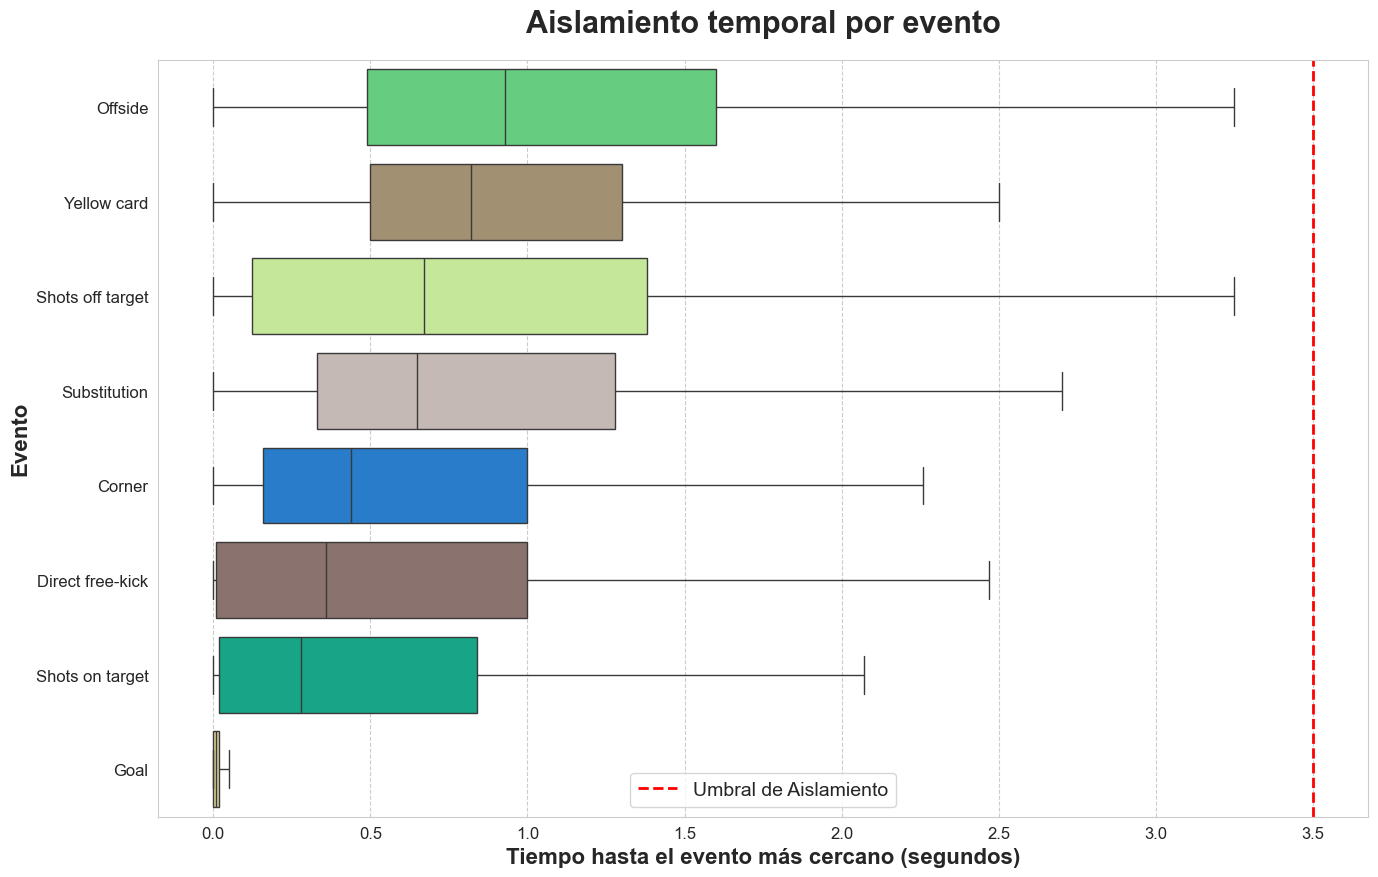

In [25]:
# Ordenar los datos cronológicamente por partido
df_detalle_final.sort_values(by=["game_index", "mitad", "instante_minutos"], inplace=True)

# Calcular la diferencia de tiempo, agrupando por partido y por mitad
#df_detalle_final["tiempo_desde_anterior"] = df_detalle_final.groupby("game_index")["instante_minutos"].diff()
#df_detalle_final["tiempo_hasta_siguiente"] = df_detalle_final.groupby("game_index")["instante_minutos"].diff(-1) * -1
df_detalle_final["tiempo_desde_anterior"] = df_detalle_final.groupby(["game_index", "mitad"])["instante_minutos"].diff()
df_detalle_final["tiempo_hasta_siguiente"] = df_detalle_final.groupby(["game_index", "mitad"])["instante_minutos"].diff(-1) * -1

# Calcular el tiempo al evento más cercano (el mínimo entre el anterior y el siguiente)
# Rellenamos los valores nulos (primer y último evento de un partido) con un valor grande (infinito) para que no afecten al cálculo del mínimo.
df_detalle_final["aislamiento_temporal"] = df_detalle_final[["tiempo_desde_anterior", "tiempo_hasta_siguiente"]].min(axis=1)

# Calcular el orden de los eventos basado en la mediana del aislamiento
order = df_detalle_final.groupby("label")["aislamiento_temporal"].median().sort_values(ascending=False).index

#plt.figure(figsize=(18, 10))
ax = sns.boxplot(
    data=df_detalle_final,
    x="aislamiento_temporal",
    y="label",
    order=order,
    showfliers=False, # para una mejor visualización de las cajas
    #showfliers=True,
    palette="terrain",
    hue="label",
    legend=False,
)

plt.title("Aislamiento temporal por evento", fontsize=22, weight="bold", pad=20)
plt.xlabel("Tiempo hasta el evento más cercano (segundos)", weight="bold")
plt.ylabel("Evento", weight="bold")
plt.axvline(3.5, color="red", linestyle="--", linewidth=2, label="Umbral de Aislamiento")
plt.legend()

# Mejorar legibilidad
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.4)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

- Comparación entre eventos:
    - Al comparar las cajas de diferentes eventos, podemos identificar cuáles son los eventos más aislados temporalmente (con medianas y cajas más hacia la derecha) y cuáles tienden a ocurrir en secuencias más rápidas con otros eventos (con medianas y cajas más hacia la izquierda).
- Este análisis es también importante para identificar eventos que son más susceptibles de ser detectados de forma aislada en los videos.
- Un evento con un alto grado de aislamiento temporal es menos probable que esté superpuesto o que ocurra simultáneamente con otros eventos relevantes.
- Para un modelo-IA de detección de eventos basado en características visuales en videos, los eventos que ocurren en momentos más limpios (aislados) suelen ser más fáciles de aprender y detectar de manera precisa.
- Los eventos que ocurren muy juntos pueden ser difíciles de distinguir visualmente.
- Por tanto, este nuevo hallazgo justifica la exclusión de eventos con bajo aislamiento temporal.

In [26]:
lista_eventos_final = lista_eventos
lista_eventos_final.remove("Shots on target")
lista_eventos_final.remove("Direct free-kick")

# filtrando eventos
df_detalle_final = df_detalle_final[df_detalle_final["label"].isin(lista_eventos_final)]
lista_eventos = fn_listar_eventos_unicos(df_detalle_final, "label", pri=True)

"Corner"
"Offside"
"Shots off target"
"Goal"
"Yellow card"
"Substitution"


**6.4. Justificando los 4 eventos finales:**
- Después de aplicar los criterios de filtrado basados en la frecuencia y relevancia, la visibilidad y el aislamiento temporal, hemos llegado a un conjunto más reducido de eventos considerados clave y adecuados para ser detectados por un modelo de aprendizaje profundo a partir de videos con vista isométrica.
- La exclusión de ciertos eventos se justifica de la siguiente manera:
    - Eventos con baja frecuencia o relevancia para un video-resumen:
        - Si bien eventos como 'Ball out of play', 'Throw-in', y 'Foul' ocurren con alta frecuencia, su relevancia individual para un video-resumen de los momentos más importantes del partido suele ser menor en comparación con eventos de alto impacto. Por otro lado, eventos extremadamente raros como 'Penalty' o las tarjetas rojas directas y por doble amarilla ('Red card', 'Yellow->red card') no ofrecen suficientes ejemplos para que un modelo aprenda a detectarlos de manera fiable.
    - Eventos con baja visibilidad:
        - El análisis de visibilidad reveló que algunos eventos, a pesar de tener una frecuencia moderada, a menudo no son completamente visibles en la toma de la cámara. Por ejemplo, 'Kick-off', 'Clearance' y 'Indirect free-kick' mostraron porcentajes significativos de ocurrencias donde el evento no fue etiquetado como "visible". Dado que nuestro modelo se basará en el análisis visual de los frames, incluir eventos con baja visibilidad intrínseca introduciría ruido y dificultaría el aprendizaje efectivo.
    - Eventos con bajo aislamiento temporal:
        - El análisis del aislamiento temporal es particularmente importante para la tarea de detección, ya que buscamos eventos que ocurran en momentos relativamente "limpios" del partido, donde la acción principal no esté superpuesta con otros eventos. En este sentido, eventos como 'Shots on target' y 'Direct free-kick' mostraron, en promedio, un menor aislamiento temporal. Esto sugiere que a menudo ocurren en rápida sucesión o simultáneamente con otras acciones, lo que dificultaría a un modelo visual discriminar claramente el momento exacto y las características visuales distintivas de estos eventos en comparación con acciones inmediatamente anteriores o posteriores.
- Justificación específica para 'Shots off target' y 'Offside':
    - Considerando lo anterior y retomando los aspectos de la sección 6:
        - 'Shots off target': Aunque tienen una frecuencia razonable, el análisis de aislamiento temporal indica que a menudo no ocurren en momentos lo suficientemente "limpios" para una detección visual precisa. Además, desde la perspectiva de un video-resumen, un tiro fuera suele tener menos impacto que un tiro a puerta. La combinación de un aislamiento temporal no ideal y una menor relevancia justifca su exclusión.
        - 'Offside': Este evento presenta desafíos significativos en la detección visual desde una perspectiva isométrica. La decisión de fuera de juego a menudo depende de la posición relativa de varios jugadores en un instante preciso y de la línea defensiva, información que puede no ser completamente clara o fácilmente discernible a través de la vista isométrica y sin contexto adicional. Esto lo convierte en un evento complejo para un modelo visual.
- Al centrarnos en los eventos restantes ('Goal', 'Yellow card', 'Substitution', 'Corner'), seleccionamos clases que:
    - Tienen una frecuencia suficiente para un aprendizaje efectivo.
    - Poseen un alto porcentaje de visibilidad, lo que facilita la extracción de características visuales relevantes.
    - Demuestran un mayor aislamiento temporal, lo que reduce la ambigüedad temporal y espacial para el modelo.
    - Son de alto impacto o relevancia para la creación de un video-resumen de los momentos clave de un partido de fútbol.
- Este proceso de filtrado, basado en un análisis riguroso de las características del dataset en relación con los requisitos de un modelo de detección visual, nos permite construir un conjunto de datos más robusto y enfocado en los eventos más prometedores para el éxito del proyecto.

**¿Por qué no exluimos "Goal"? Pues un video-resumen sin goles no atrae ni impacta. Este evento es no negociable y es considerado el primer evento clave a clasificar (justificado en la agrupación de aspectos).**

In [27]:
lista_eventos_final = lista_eventos
lista_eventos_final.remove("Offside")
lista_eventos_final.remove("Shots off target")

# filtrando eventos
df_detalle_final = df_detalle_final[df_detalle_final["label"].isin(lista_eventos_final)]
lista_eventos = fn_listar_eventos_unicos(df_detalle_final, "label", pri=True)

"Corner"
"Goal"
"Yellow card"
"Substitution"


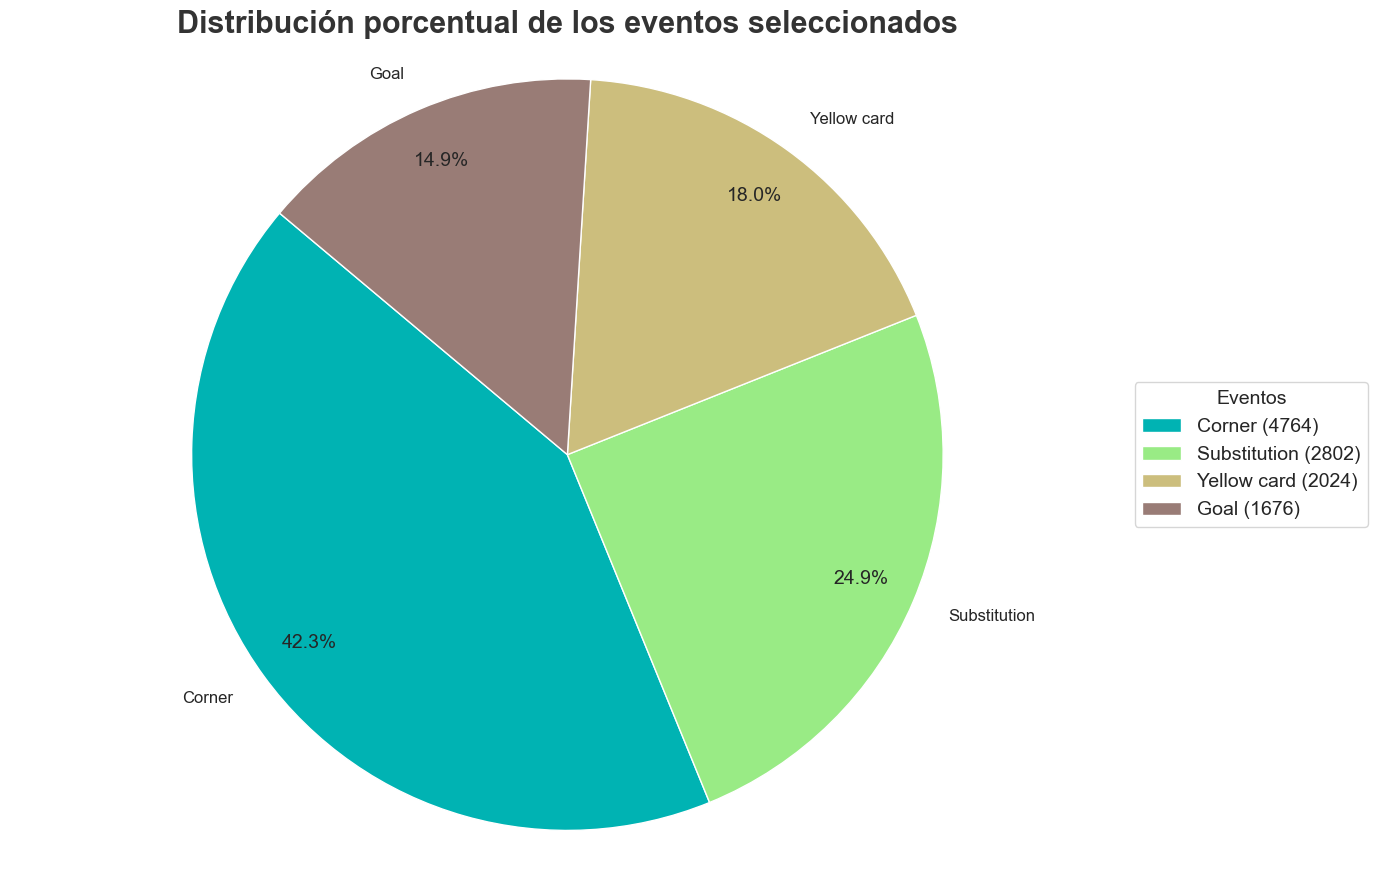

In [35]:
# Calcular las frecuencias de los eventos seleccionados
event_counts = df_detalle_final["label"].value_counts()

# Crear el gráfico de tarta
#plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    event_counts,
    labels=event_counts.index,
    autopct="%1.1f%%",  # Mostrar porcentajes con un decimal
    startangle=140,
    colors=sns.color_palette("terrain", len(event_counts)), # Usar la misma paleta
    wedgeprops=dict(edgecolor="white"), # Añadir borde a las secciones
    pctdistance=0.85 # Ajusta la distancia de los porcentajes al centro
)

# Añadir las etiquetas de frecuencia
labels = [f"{label} ({count})" for label, count in event_counts.items()]
plt.legend(wedges, labels, title="Eventos", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


plt.title("Distribución porcentual de los eventos seleccionados", fontsize=22, weight="bold", color="#333333")
plt.axis("equal")  # gráfico de tarta sera circular

plt.tight_layout()
plt.show()